# GPT로 코드 받아 확인해보는 Option Study 

- 책 읽으며 헷갈리는 부분 즉석해서 GPT로 코드구현

## ITM, OTM, ATM premium 어떻게 되나 시각화. 

- 감을 잡자. 

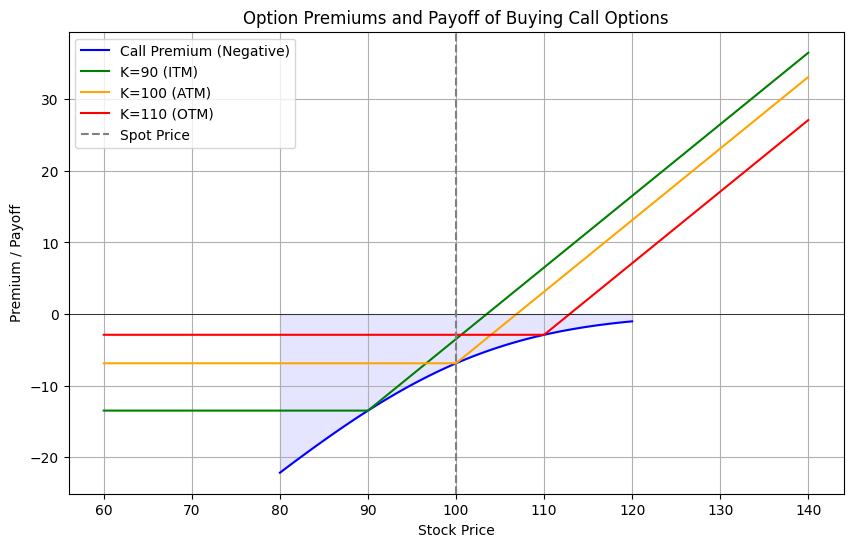

In [6]:
import QuantLib as ql
import matplotlib.pyplot as plt
import numpy as np

# Parameters
spot = 100
vol = 0.2
rate = 0.05
div = 0.0
expiry = 0.5  # in years

# Setup QuantLib
calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)
day_count = ql.Actual365Fixed()
settlement_date = ql.Date.todaysDate()
ql.Settings.instance().evaluationDate = settlement_date

# Black-Scholes process
bsm_process = ql.BlackScholesMertonProcess(
    ql.QuoteHandle(ql.SimpleQuote(spot)),
    ql.YieldTermStructureHandle(ql.FlatForward(settlement_date, div, day_count)),
    ql.YieldTermStructureHandle(ql.FlatForward(settlement_date, rate, day_count)),
    ql.BlackVolTermStructureHandle(ql.BlackConstantVol(settlement_date, calendar, vol, day_count))
)

# Option premiums vs strike
strikes = np.linspace(80, 120, 100)
premiums = []

for strike in strikes:
    payoff = ql.PlainVanillaPayoff(ql.Option.Call, strike)
    exercise = ql.EuropeanExercise(settlement_date + ql.Period(int(expiry*365), ql.Days))
    option = ql.VanillaOption(payoff, exercise)
    option.setPricingEngine(ql.AnalyticEuropeanEngine(bsm_process))
    premiums.append(-option.NPV())  # Negative for buying

# Option payoffs for K=90, 100, 110
buy_strikes = [90, 100, 110]
buy_premiums = {}

for K in buy_strikes:
    payoff = ql.PlainVanillaPayoff(ql.Option.Call, K)
    exercise = ql.EuropeanExercise(settlement_date + ql.Period(int(expiry*365), ql.Days))
    option = ql.VanillaOption(payoff, exercise)
    option.setPricingEngine(ql.AnalyticEuropeanEngine(bsm_process))
    buy_premiums[K] = option.NPV()

# Stock price range
S = np.linspace(60, 140, 400)

# Calculate payoffs
payoffs = {}
for K in buy_strikes:
    payoffs[K] = np.maximum(S - K, 0) - buy_premiums[K]

# Plotting
plt.figure(figsize=(10,6))

# Plot premium vs strike (mirrored)
plt.plot(strikes, premiums, color='blue', label='Call Premium (Negative)')
plt.fill_between(strikes, premiums, color='blue', alpha=0.1)

# Plot payoffs
colors = ['green', 'orange', 'red']
for i, K in enumerate(buy_strikes):
    label = f'K={K} ({ "ITM" if K < spot else "ATM" if K == spot else "OTM" })'
    plt.plot(S, payoffs[K], color=colors[i], label=label)

plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(x=spot, color='grey', linestyle='--', label='Spot Price')

plt.xlabel('Stock Price')
plt.ylabel('Premium / Payoff')
plt.title('Option Premiums and Payoff of Buying Call Options')
plt.legend()
plt.grid(True)
plt.show()
